# Zadanie 3

Zadanie zostało zrobione na podstawie kursu z datacamp : https://campus.datacamp.com/courses/intermediate-deep-learning-with-pytorch/images-convolutional-neural-networks?ex=5 
Oraz artykułu cs231 : https://cs231n.github.io/convolutional-networks/?utm_source=chatgpt.com

Używam Clouds dataset ( 7 klas ) - z kaggla

https://www.kaggle.com/datasets/jockeroika/clouds-photos/data

Libraries

In [2]:
import kagglehub
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
from torchmetrics import Precision, Recall
import torch
import random
import numpy as np

c:\Users\egrac\Desktop\Uni\Uczenie maszynowe semestr 5\Lista 3\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Downloading data

In [3]:

# getting path to dataset
path = kagglehub.dataset_download("jockeroika/clouds-photos")


Transformers for input images

In [4]:

train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.RandomAutocontrast(),
    transforms.ToTensor(),
    transforms.Resize((64, 64)),
])

test_tranforms = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((64, 64)),
    ])

Preparing dataloader

In [5]:
dataset_train = ImageFolder(
    path + "/clouds_train",
    transform=train_transforms,   
)

dataloader_train = DataLoader(
    dataset_train,
    batch_size = 32,
    shuffle=True
)

dataset_test = ImageFolder(
    path +"/clouds_test",
    transform=test_tranforms
)

dataloader_test = DataLoader(
    dataset_test,
)

Convolutional Neural Networks

Dlaczego ELU a nie RELU - ELU wymierających neuronów


Architektura sieci - artykuł cs231

![image](images/architecture.png)



Budowa sieci podstawowej:
    (Conv -> Elu)x2 -> MaxPool ->(Conv -> Elu)x2 -> MaxPool -> Conv->Elu -> MaxPool -> AdaptiveAvg -> DenseLayer


In [6]:


class Net1(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.features_extractor = nn.Sequential(
            
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ELU(),
            # teraz mamy 32 x 64 x 64

            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ELU(),
            # teraz mamy 32 x 64 x 64

            nn.MaxPool2d(kernel_size=2),
            # teraz mamy 64 x 32 x 32

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ELU(),
            # teraz mamy 64 x 64 x 64
            
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ELU(),
            # teraz mamy 64 x 64 x 64
            
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ELU(),
            # teraz mamy 128 x 32 x 32

            nn.MaxPool2d(kernel_size=2),
            # teraz mamy 128 x 16 x 16 (jest to bardzo dużo wag - zwiększa ryzyko overfittingu)

            nn.AdaptiveAvgPool2d((1,1)),
            # adaptive avg pool przeciwdziała przeuczeniu się modelu

            nn.Flatten(),
            # teraz mamy 128 

            
        )
    
        # dense layer at the end
        self.classifier = nn.Linear(128, num_classes)
        
    def forward(self, x):
        x = self.features_extractor(x)
        x = self.classifier(x)
        return x
    


In [7]:
class Net2(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.features_extractor = nn.Sequential(
            
            
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ELU(),
            # teraz mamy 32 x 64 x 64

            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ELU(),
            # teraz mamy 32 x 64 x 64

            nn.MaxPool2d(kernel_size=2),
            # teraz mamy 64 x 32 x 32


            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ELU(),
            # teraz mamy 64 x 64 x 64
            
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ELU(),
            # teraz mamy 64 x 64 x 64
            
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            #batchnormalization
            nn.BatchNorm2d(128),
            
            nn.ELU(),
            # teraz mamy 128 x 32 x 32

            nn.MaxPool2d(kernel_size=2),
            # teraz mamy 128 x 16 x 16 (jest to bardzo dużo wag - zwiększa ryzyko overfittingu)

            nn.AdaptiveAvgPool2d((1,1)),
            # adaptive avg pool przeciwdziała przeuczeniu się modelu

            nn.Flatten(),
            # teraz mamy 128 

            
        )
    
        # dense layer at the end
        self.classifier = nn.Linear(128, num_classes)
        
    def forward(self, x):
        x = self.features_extractor(x)
        x = self.classifier(x)
        return x


Batchnormalization pomaga sieci w uczeniu się (stabilizuje proces uczenia się naszej sieci)

In [8]:

class Net3(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.features_extractor = nn.Sequential(
            
            
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ELU(),
            # teraz mamy 32 x 64 x 64

            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ELU(),
            # teraz mamy 32 x 64 x 64

            nn.MaxPool2d(kernel_size=2),
            # teraz mamy 32 x 32 x 32


            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ELU(),
            # teraz mamy 64 x 32 x 32
            
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ELU(),
            # teraz mamy 64 x 32 x 32
            
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ELU(),
            # teraz mamy 128 x 32 x 32

            nn.MaxPool2d(kernel_size=2),
            # teraz mamy 128 x 16 x 16 (jest to bardzo dużo wag - zwiększa ryzyko overfittingu)

            nn.AdaptiveAvgPool2d((1,1)),
            # adaptive avg pool przeciwdziała przeuczeniu się modelu

            nn.Flatten(),
            # teraz mamy 128 

            # dropout, żeby przeciwdziałać overfittingowi
            nn.Dropout(p=0.05),
            
        )

        self.classifier = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.features_extractor(x)
        x = self.classifier(x)
        return x


Dropout zapobiega przeuczaniu się sieci konwolucyjnej, lecz przy naszej sieci i małym zbiorze uczącym ma ona znikomy wpływ, lub czasem negatywny

In [9]:

net1 = Net1(num_classes=7)
net2 = Net2(num_classes=7)
net3 = Net3(num_classes=7)


In [17]:

criterion = nn.CrossEntropyLoss()
optimizer1 = optim.Adam(net1.parameters(), lr=0.001)
optimizer2 = optim.Adam(net2.parameters(), lr=0.001)
optimizer3 = optim.Adam(net3.parameters(), lr=0.001)

for epoch in range(20):
    for images, labels in dataloader_train:
        optimizer1.zero_grad()
        optimizer2.zero_grad()
        optimizer3.zero_grad()
        outputs1 = net1(images)
        outputs2 = net2(images)
        outputs3 = net3(images)
        loss1 = criterion(outputs1, labels)
        loss2 = criterion(outputs2, labels)
        loss3 = criterion(outputs3, labels)
        loss1.backward()
        optimizer1.step()
        loss2.backward()
        optimizer2.step()
        loss3.backward()
        optimizer3.step()

In [16]:

import torch
from torchmetrics.classification import Accuracy

def eval_accuracy(net, dataloader, num_classes=7):
    net.eval()
    acc = Accuracy(task="multiclass", num_classes=num_classes)

    with torch.no_grad():
        for images, labels in dataloader:
            outputs = net(images)
            preds = outputs.argmax(dim=1)
            acc.update(preds, labels)
    return acc.compute().item()

a1 = eval_accuracy(net1, dataloader_test, 7)
a2 = eval_accuracy(net2, dataloader_test, 7)
a3 = eval_accuracy(net3, dataloader_test, 7)

print("net1 acc:", a1)
print("net2 acc:", a2)
print("net3 acc:", a3)



net1 acc: 0.6502057909965515
net2 acc: 0.31069958209991455
net3 acc: 0.6028806567192078


Ważna notka, sieć dobrze działą ze sztucznym transfer learningiem, po pierwszym uczeniu wyniki są słąbe, ale po drugim uczeniu bez tworzenia nowej sieci tylko uczenie <br> na starych accuraccy skacze do ok 80%

test

In [12]:
dataset = ImageFolder(
    "C:\\Users\\egrac\\Desktop\\Uni\\Uczenie maszynowe semestr 5\\Lista 3\\test_image",
    transform = test_tranforms  
)

In [13]:
dataloader = DataLoader(
    dataset,
)

{'cirriform clouds': 0, 'clear sky': 1, 'cumulonimbus clouds': 2, 'cumulus clouds': 3, 'high cumuliform clouds': 4, 'stratiform clouds': 5, 'stratocumulus clouds': 6}
torch.Size([64, 64, 3])


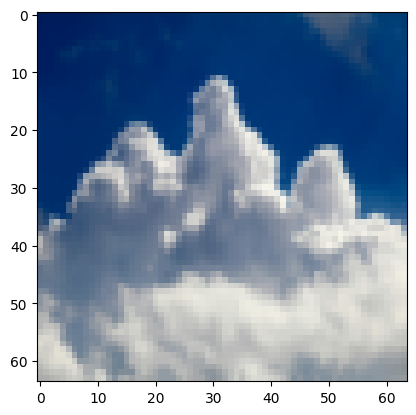

tensor([2])
torch.Size([64, 64, 3])


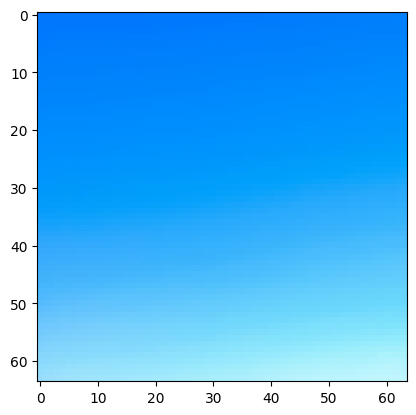

tensor([1])
torch.Size([64, 64, 3])


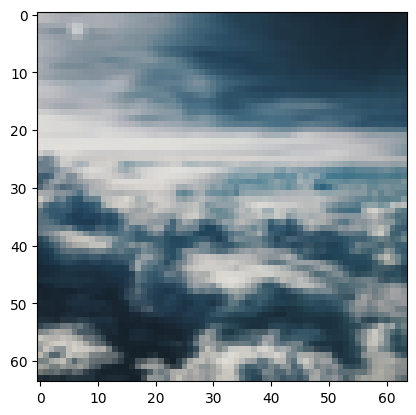

tensor([3])
torch.Size([64, 64, 3])


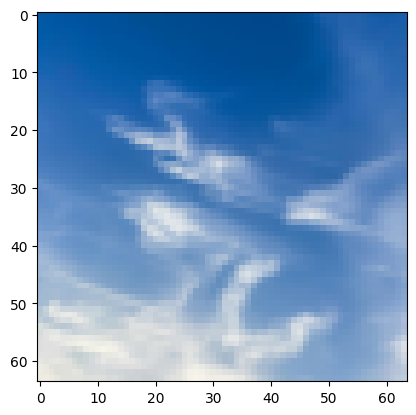

tensor([2])


In [18]:
print(dataset_test.class_to_idx)
for image, _ in dataloader:
    image1 = image.squeeze(0).permute(1, 2, 0)
    print(image1.shape)
    plt.imshow(image1) 
    plt.show() 
    output = net3(image)
    print(output.argmax(dim=1))
